In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

#to see full text:
pd.set_option("display.max_colwidth", -1)

print(colored("\nNECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["bold", "dark"]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...



NECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...


In [ ]:
data = pd.read_csv("/content/spam.csv", encoding = "ISO-8859-1", engine = "python")

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...",  color = "green", attrs = ["bold", "dark"]))


DATASETS WERE SUCCESFULLY LOADED...


In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [ ]:
#rename dataset columns
data.rename(columns = {"v1": "target", "v2": "text"}, inplace = True)

#drop unnecessary columns
data.drop(["Unnamed: 2","Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)

print(colored("\nOPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...",  color = "green", attrs = ["bold", "dark"]))


OPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...


In [ ]:
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [ ]:
data.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
print(colored("There are {} duplicated values in the dataset".format(data.duplicated().sum()), color = "green", attrs = ["bold", "dark"]))

There are 403 duplicated values in the dataset


In [ ]:
data.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", color = "green", attrs = ["bold", "dark"]))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [ ]:
grouped_target = data.groupby("target").count()
grouped_target["text"]

target
ham     4516
spam    653 
Name: text, dtype: int64

In [ ]:
data.isnull().sum()

target    0
text      0
dtype: int64

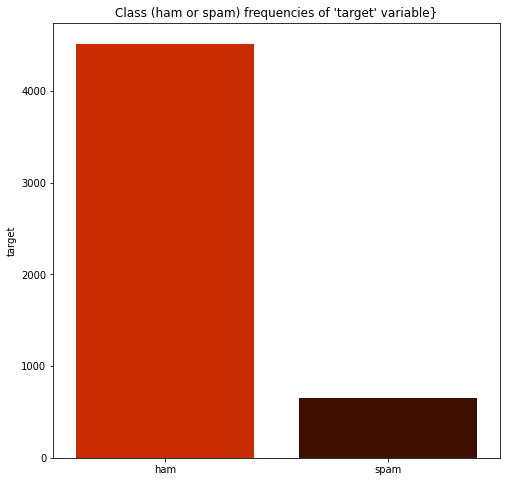

In [ ]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "white")

sns.barplot(x = data["target"].value_counts().index,
            y = data["target"].value_counts(), palette = ["#C82C02", "#410F01"],
            saturation = 1).set(title = "Class (ham or spam) frequencies of 'target' variable}");

In [ ]:
fig = px.pie(data_frame = data, names = "target", hole = 0.4, title = "counts in 'target' variable",
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.5, color = "#410F01")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

## <span style='background:yellow;color:#000000;'>New features</span>

* #### <span style='background:blue;color:#ffffff;'>ch_no: number of characters in the texts</span>
* #### <span style='background:red;color:#ffffff;'>wd_no: number of words in the texts</span>
* #### <span style='background:green;color:#ffffff;'>sn_no: number of sentences in the texts</span>

In [ ]:
data["ch_no"] = data["text"].apply(len)
data["wd_no"] = data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
data["sn_no"] = data.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

data.describe().T.style.background_gradient(cmap = "Purples_r")

,count,mean,std,min,25%,50%,75%,max
ch_no,5169.000000,78.977945,58.236293,2.000000,36.000000,60.000000,117.000000,910.000000
wd_no,5169.000000,18.453279,13.324793,1.000000,9.000000,15.000000,26.000000,220.000000
sn_no,5169.000000,1.947185,1.362406,1.000000,1.000000,1.000000,2.000000,28.000000


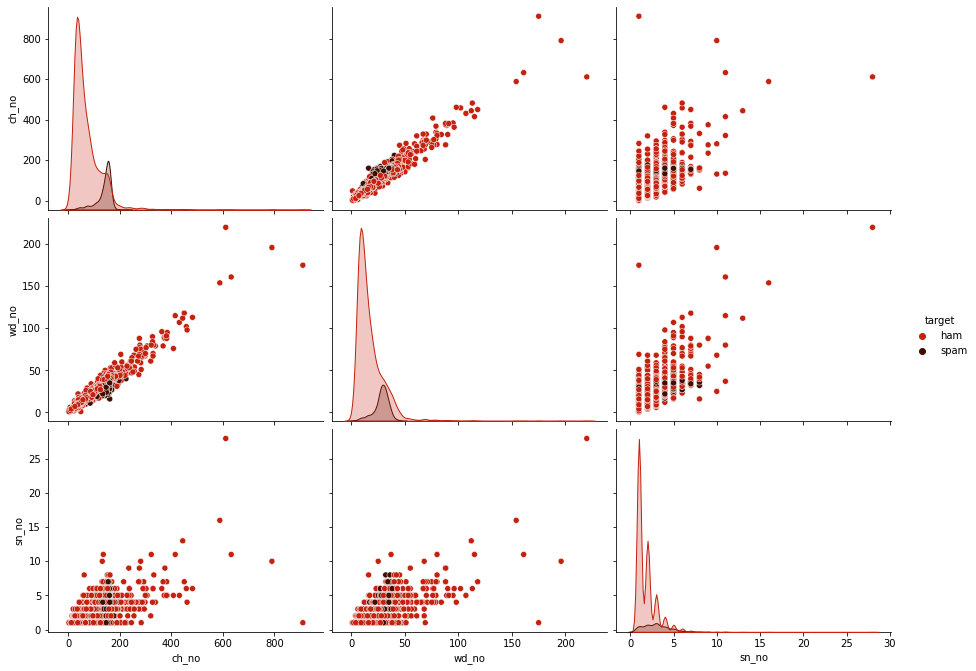

In [ ]:
fig = sns.pairplot(data = data, hue = "target", palette = ["#C4210E", "#410F01"], height = 3.15, aspect = 1.35)
plt.show(fig);

In [ ]:
data["text"] = data["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nUPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...", color = "green", attrs = ["bold", "dark"]))


UPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...


In [ ]:
data["text"] = data["text"].str.replace('[^\w\s]','')

print(colored("\nPUNCTUATION MARKS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))


PUNCTUATION MARKS WERE SUCCESFULLY DELETED...


In [ ]:
data["text"] = data["text"].str.replace('\d','')

print(colored("\nNUMBERS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))


NUMBERS WERE SUCCESFULLY DELETED...


In [ ]:
stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

data["text"] = data["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

print(colored("\nSTOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...", color = "green", attrs = ["bold", "dark"]))


STOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...


In [ ]:
data["text"] = data["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nTEXTS WERE SUCCESFULLY LEMMATIZED...", color = "green", attrs = ["bold", "dark"]))


TEXTS WERE SUCCESFULLY LEMMATIZED...


In [ ]:
data["text"] = data["text"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

print(colored("\nURLs WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))


URLs WERE SUCCESFULLY REMOVED...


In [ ]:
data["text"] = data["text"].apply(lambda x: ' '.join([x for x in x.split() if len(x) > 3]))

print(colored("\nWORDS LESS THAN 3 LETTERS LONG WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))


WORDS LESS THAN 3 LETTERS LONG WERE SUCCESFULLY REMOVED...


In [ ]:
data.head(n = 10)

,target,text,ch_no,wd_no,sn_no
0,ham,jurong point crazy available bugis great world buffet cine amore,111,24,2
1,ham,joking,29,8,2
2,spam,free entry wkly comp final tkts text receive entry questionstd ratetcs apply over,155,37,2
3,ham,early already,49,13,1
4,ham,dont think life around though,61,15,1
5,spam,freemsg darling week word back like still chgs send,148,39,4
6,ham,even brother like speak treat like patent,77,18,2
7,ham,request melle melle minnaminunginte nurungu vettam callertune caller press copy friend callertune,160,31,2
8,spam,winner valued network customer selected receivea prize reward claim call claim code valid hour,158,32,5
9,spam,mobile month entitled update latest colour mobile camera free call mobile update free,154,31,3


In [ ]:
corpus = []
for i in data.text:
    for j in i.split():
        corpus.append(j.strip())

In [ ]:
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

{'call': 509,
 'dont': 258,
 'ltgt': 254,
 'know': 248,
 'free': 245,
 'like': 234,
 'come': 228,
 'time': 224,
 'good': 218,
 'want': 208,
 'text': 197,
 'love': 184,
 'need': 178,
 'send': 165,
 'going': 165}

<function matplotlib.pyplot.show(close=None, block=None)>

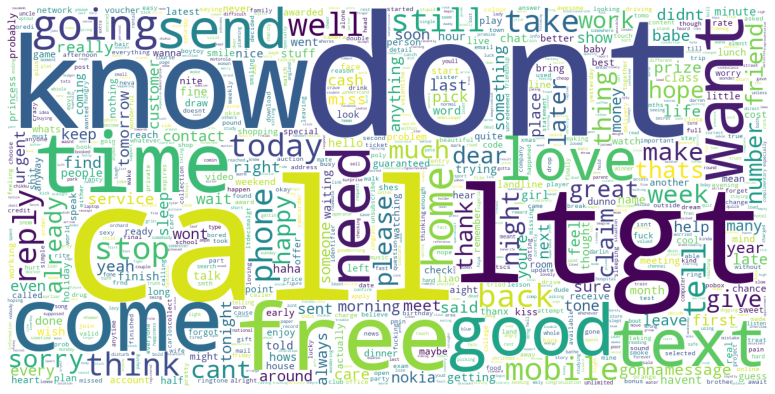

In [ ]:
text = " ".join(i for i in data.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

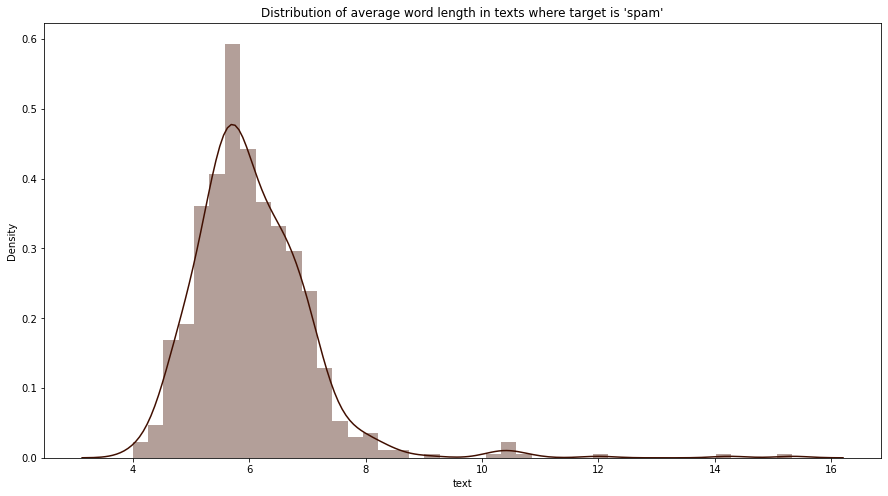

In [ ]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "spam"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'spam'");

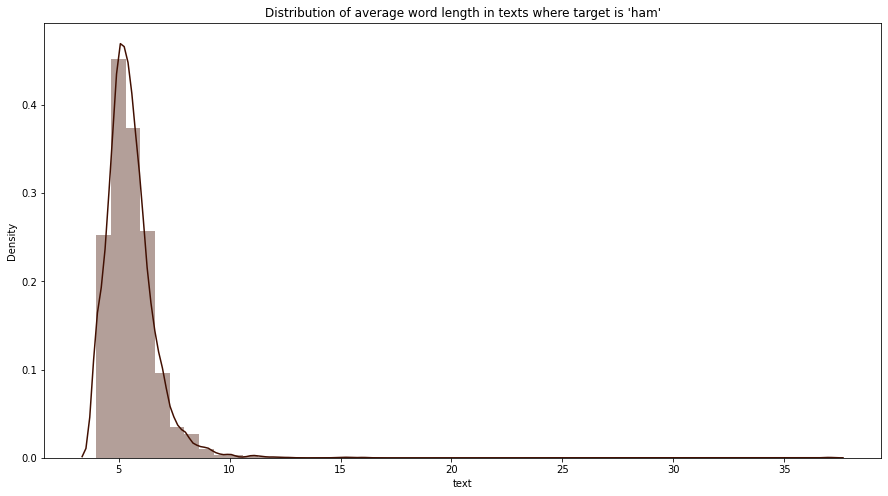

In [ ]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "ham"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'ham'");

In [ ]:
lb = LabelEncoder()
data["target"] = lb.fit_transform(data["target"])

In [ ]:
x = data["text"]
y = data["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDATASET WAS SUCCESFULLY DIVIDED ...", color = "green", attrs = ["bold", "dark"]))


DATASET WAS SUCCESFULLY DIVIDED ...


In [ ]:
print("The shape of 'train_x' is {} and the shape of 'test_x' is {}".format(train_x.shape[0], test_x.shape[0]))

The shape of 'train_x' is 4135 and the shape of 'test_x' is 1034


In [ ]:
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(tokenized_train, maxlen = None)
test_x = sequence.pad_sequences(tokenized_test, maxlen = None)

In [ ]:
GLOVE_EMBEDDING = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

#_________________________________________________________________________________________#

#_________________________________________________________________________________________#

embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(6012, len(word_index))+1

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 6012:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [ ]:
model = Sequential()

model.add(Embedding(6013, output_dim = 100, weights = [embedding_matrix], trainable = False))

model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3, dropout = 0.5))

model.add(LSTM(units = 64, recurrent_dropout = 0.3, dropout = 0.5))

model.add(Dense(units = 32, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01), loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         601300    
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 770,069
Trainable params: 168,769
Non-trainable params: 601,300
_________________________________________________________________


In [ ]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 64,
                    validation_data = (test_x, test_y),
                    epochs = 20,
                    callbacks = [lr_reduce])

Epoch 1/20
65/65 [==============================] - 40s 522ms/step - loss: 0.2292 - accuracy: 0.9103 - val_loss: 0.1418 - val_accuracy: 0.9507
Epoch 2/20
65/65 [==============================] - 33s 508ms/step - loss: 0.1082 - accuracy: 0.9632 - val_loss: 0.1512 - val_accuracy: 0.9536
Epoch 3/20
65/65 [==============================] - 33s 507ms/step - loss: 0.1008 - accuracy: 0.9664 - val_loss: 0.1227 - val_accuracy: 0.9632
Epoch 4/20
65/65 [==============================] - 33s 510ms/step - loss: 0.0859 - accuracy: 0.9705 - val_loss: 0.1244 - val_accuracy: 0.9671
Epoch 5/20
65/65 [==============================] - 33s 508ms/step - loss: 0.0866 - accuracy: 0.9707 - val_loss: 0.1275 - val_accuracy: 0.9691
Epoch 6/20
65/65 [==============================] - 33s 509ms/step - loss: 0.0665 - accuracy: 0.9792 - val_loss: 0.1289 - val_accuracy: 0.9662
Epoch 7/20
65/65 [==============================] - 33s 503ms/step - loss: 0.0667 - accuracy: 0.9787 - val_loss: 0.1220 - val_accuracy: 0.9700

In [ ]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

130/130 [==============================] - 6s 39ms/step - loss: 0.0122 - accuracy: 0.9969
Model accuracy on the train set:  0.9968560934066772
33/33 [==============================] - 1s 27ms/step - loss: 0.1585 - accuracy: 0.9700
Model accuracy on the test set:  0.9700193405151367


### <span style = "background:#410F01; border:black solid; font-size:100%; color:#fff; border-radius:5px;">Visualization of the model percent</span>

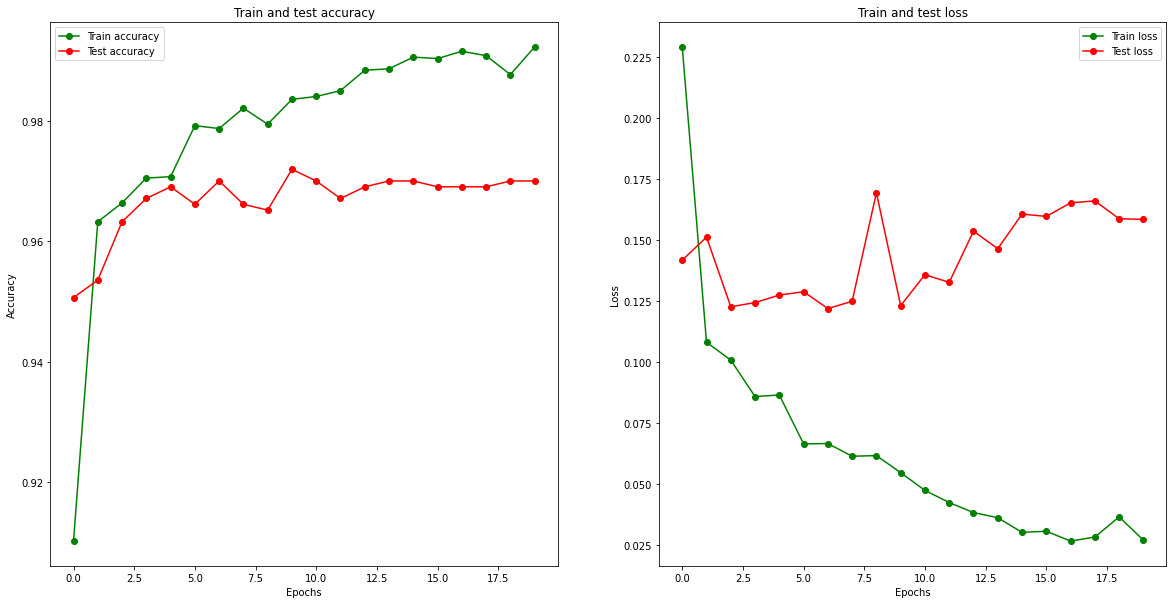

In [ ]:
epochs = [i for i in range(20)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       896
           1       0.00      0.00      0.00       138

    accuracy                           0.87      1034
   macro avg       0.43      0.50      0.46      1034
weighted avg       0.75      0.87      0.80      1034



[[896   0]
 [138   0]]


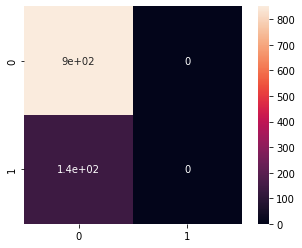

In [ ]:
conf_mat = confusion_matrix(test_y, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

In [ ]:
def predict_message(message):
    message = message.lower()
    message = re.sub('[^\w\s]', '', message)
    message = re.sub('\d', '', message)
    message = " ".join(word for word in message.split() if word not in stop_words)
    message = " ".join([Word(word).lemmatize() for word in message.split()])
    tokenized_message = tokenizer.texts_to_sequences([message])
    padded_message = sequence.pad_sequences(tokenized_message, maxlen=train_x.shape[1])
    prediction = model.predict(padded_message)
    if prediction >= 0.5:
        return "Spam"
    else:
        return "Ham"
example_message = "Congratulations! You have been selected as the lucky winner of a $10,000 prize! Act fast to claim your reward. This is a limited-time offer and only available to select individuals like yourself. Click the link below to secure your prize now: scam-link.com. Don't miss out on this amazing opportunity to become financially free. Our previous winners have already received their cash, and now it's your turn! Simply provide your name, address, and credit card details to ensure the funds are transferred to your account immediately. Hurry, before the offer expires!"

# Dự đoán tin nhắn và in ra kết quả
print("Prediction:", predict_message(example_message))


Prediction: Spam
